## Obejective
- Create a streamlit app to predict california house price

## Info
- Ref: https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
- Column Description
    - longitude: A measure of how far west a house is; a higher value is farther west
    - latitude: A measure of how far north a house is; a higher value is farther north
    - housingMedianAge: Median age of a house within a block; a lower number is a newer building
    - totalRooms: Total number of rooms within a block
    - totalBedrooms: Total number of bedrooms within a block
    - population: Total number of people residing within a block
    - households: Total number of households, a group of people residing within a home unit, for a block
    - medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
    - medianHouseValue: Median house value for households within a block (measured in US Dollars)
    - oceanProximity: Location of the house w.r.t ocean/sea

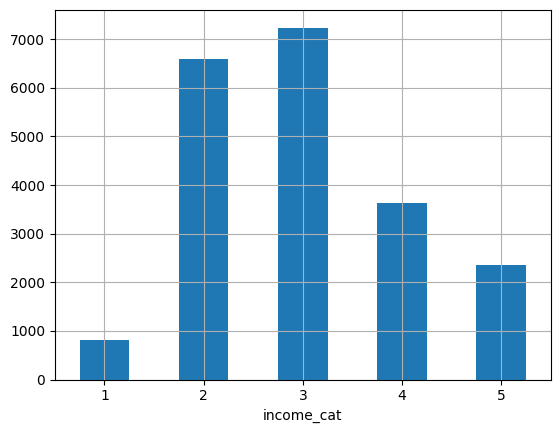

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('housing.csv')


# df = pd.read_csv('housing.csv')
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, stratify=df['income_cat'], random_state=20240417)
## Check stratification
train['income_cat'].value_counts() / len(train['income_cat'])
test['income_cat'].value_counts() / len(test['income_cat'])

income_cat
3    0.350568
2    0.318868
4    0.176287
5    0.114480
1    0.039798
Name: count, dtype: float64

income_cat
3    0.350614
2    0.318798
4    0.176357
5    0.114341
1    0.039890
Name: count, dtype: float64

In [10]:
corr_matrix = train.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686455
total_rooms           0.129861
housing_median_age    0.105019
households            0.067089
total_bedrooms        0.050168
population           -0.022726
longitude            -0.048416
latitude             -0.143447
Name: median_house_value, dtype: float64

Text(0.5, 1.0, 'Correlation Plot')

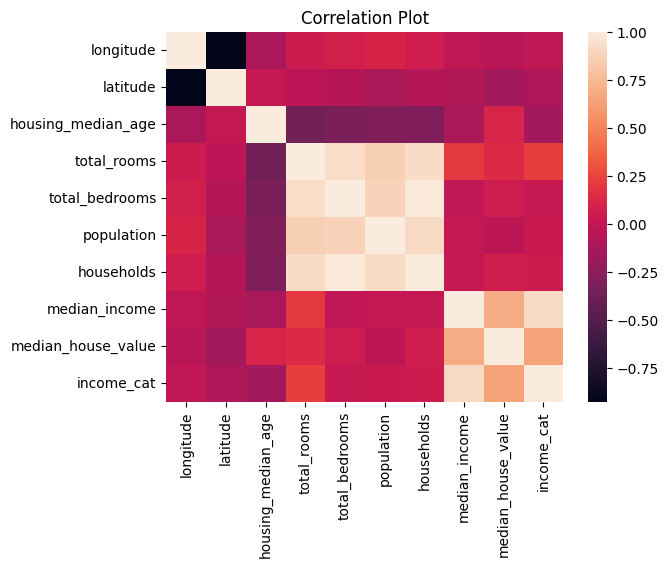

In [11]:
import seaborn as sns 
sns.heatmap(df.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')


Text(0.5, 1.0, 'Ocean Proximity Analysis for Median House Value')

<Axes: title={'center': 'Ocean Proximity Analysis for Median House Value'}, xlabel='ocean_proximity', ylabel='median_house_value'>

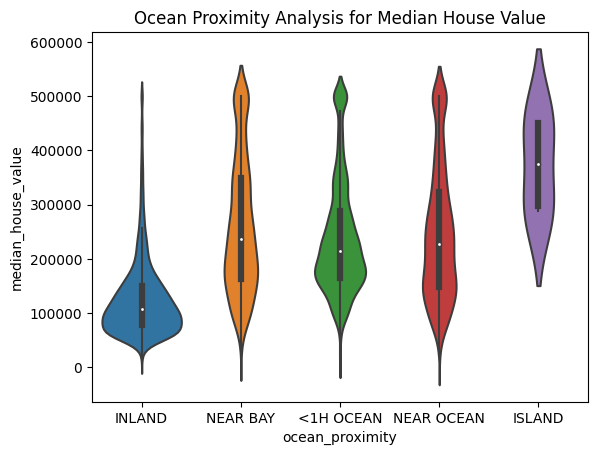

In [12]:
plt.title('Ocean Proximity Analysis for Median House Value')
sns.violinplot(x='ocean_proximity', y='median_house_value', data=train)
plt.show()

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin): 
    # Train our custom preprocessors 
    numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', ]
    categorical_columns = ['ocean_proximity', 'income_cat']
    
    def fit(self, X, y=None): 

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])
        
        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 
        
        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])
        
        return self 

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equiv
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [32]:
X_train = train.drop('median_house_value', axis=1)
y_train = train['median_house_value']
preproc = Preprocessor()
preproc.fit(X_train)
preprocessed_df = preproc.transform(X_train)
preprocessed_df.head()

Preprocessor()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_cat_1,income_cat_2,income_cat_3,income_cat_4,income_cat_5
9119,-0.723636,1.691333,1.859908,-0.495041,-0.617497,-0.728593,-0.648757,-0.863695,0,1,0,0,0,0,1,0,0,0
2023,-1.393375,1.087701,0.191558,-0.671639,-0.615171,-0.416972,-0.692475,-1.227802,0,0,0,1,0,0,1,0,0,0
12868,-0.483730,-0.311415,-0.444004,-0.583340,-0.454719,-0.092957,-0.425020,-1.078713,1,0,0,0,0,0,1,0,0,0
3943,-0.868579,1.373140,-0.523449,-0.639202,-0.668655,-0.614391,-0.646185,-0.720700,0,1,0,0,0,0,1,0,0,0
9538,-1.563308,1.214043,1.462682,-0.251319,-0.357052,-0.331099,-0.319580,-0.160014,1,0,0,0,0,0,0,1,0,0


In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
rfr = make_pipeline(Preprocessor(), RandomForestRegressor())
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestregressor', RandomForestRegressor())])

In [34]:
from sklearn.metrics import root_mean_squared_error
y_train_hat=rfr.predict(X_train)
root_mean_squared_error(y_train, y_train_hat)

11882.058945182724

In [39]:
X_test = test.drop('median_house_value', axis=1)
y_test = test['median_house_value']
y_test_hat=rfr.predict(X_test)
root_mean_squared_error(y_test, y_test_hat)

48942.67395038731

In [71]:
import dill
with open('rfr_v1.pkl', 'wb') as f:
    dill.dump(rfr, f)

In [44]:
options = {}
numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', ]
for column in numerical_columns:
    options[column] = (X_train[column].min(),  X_train[column].max())
for column in ['ocean_proximity']:
    options[column] = sorted(X_train[column].unique().tolist())

model = {
    'version': '1.0',
    'name': 'RandomForestRegressor',    
    'Comments': 'Initial model',
    'model_file': 'rfr_v1.pkl',
    'options': options,
}

import json
with open('rfr_v1_info.json', 'w') as f:
    json.dump(model, f, indent=2)

In [72]:
import dill
with open('rfr_v1.pkl', 'rb') as f:
    reloaded_model = dill.load(f)

df = pd.read_csv('housing.csv')
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']
y_hat = reloaded_model.predict(X)
root_mean_squared_error(y, y_hat)

30906.37371846427

In [55]:
import joblib
with open('streamlit_app/rfr_v1.pkl', 'wb') as f:
    joblib.dump(rfr, f, compress=9)

In [56]:
with open('streamlit_app/rfr_v1.pkl', 'rb') as f:
    r_model = joblib.load(f)

df = pd.read_csv('housing.csv')
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']
y_hat = reloaded_model.predict(X)
root_mean_squared_error(y, y_hat)

30906.37371846427

In [63]:
regressor = rfr.steps[1][1]


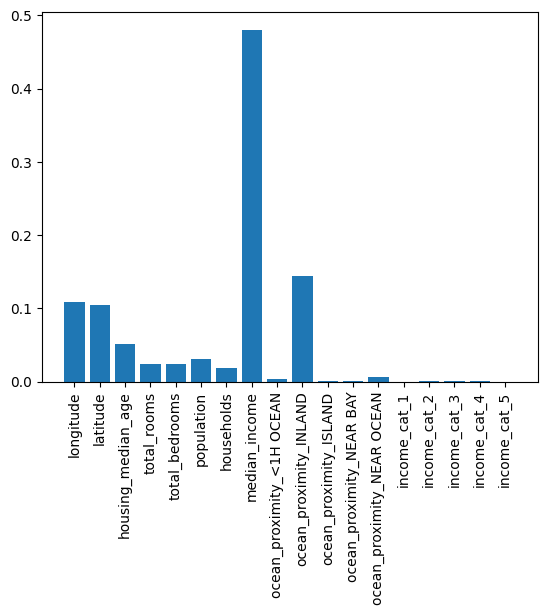

In [70]:
_ = plt.bar(regressor.feature_names_in_, regressor.feature_importances_)
_ = plt.xticks(rotation=90)